## Example of performing retrievals over a nested grid in PyDDA

In [1]:
import pyart
import pydda

import matplotlib.pyplot as plt

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



2023-10-16 13:44:17.685053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Welcome to PyDDA 1.5.1
If you are using PyDDA in your publications, please cite:
Jackson et al. (2020) Journal of Open Research Science
Detecting Jax...
Jax engine enabled!
Detecting TensorFlow...
TensorFlow detected. Checking for tensorflow-probability...
TensorFlow-probability detected. TensorFlow engine enabled!


Let's read in the data from both of the NEXRAD radars.

In [2]:
ktlx_file = pydda.tests.get_sample_file("cfrad.20110520_081431.542_to_20110520_081813.238_KTLX_SUR.nc")
kict_file = pydda.tests.get_sample_file("cfrad.20110520_081444.871_to_20110520_081914.520_KICT_SUR.nc")
radar_ktlx = pyart.io.read_cfradial(ktlx_file)
radar_kict = pyart.io.read_cfradial(kict_file)

Apply needed corrections to the radar data.

In this cell, we will apply corrections to remove nonhydrometeors from the radar data. In addition, we will apply dealiasing corrections to ensure that the radial velocity field is not impacted by aliasing. Both of these steps are required for PyDDA to create a physically realistic wind retrieval.

In [3]:
# Calculate the Velocity Texture and apply the PyART GateFilter Utilityx
vel_tex_ktlx = pyart.retrieve.calculate_velocity_texture(radar_ktlx,
                                                       vel_field='VEL',
                                                       )
vel_tex_kict = pyart.retrieve.calculate_velocity_texture(radar_kict,
                                                       vel_field='VEL',
                                                       )

## Add velocity texture to the radar objects
radar_ktlx.add_field('velocity_texture', vel_tex_ktlx, replace_existing=True)
radar_kict.add_field('velocity_texture', vel_tex_kict, replace_existing=True)

# Apply a GateFilter
gatefilter_sw = pyart.filters.GateFilter(radar_ktlx)
gatefilter_sw.exclude_above('velocity_texture', 3)
gatefilter_se = pyart.filters.GateFilter(radar_kict)
gatefilter_se.exclude_above('velocity_texture', 3)

# Apply Region Based DeAlising Utiltiy
vel_dealias_sw = pyart.correct.dealias_region_based(radar_ktlx,
                                                    vel_field='VEL',
                                                    centered=True,
                                                    gatefilter=gatefilter_sw
                                                    )

# Apply Region Based DeAlising Utiltiy
vel_dealias_se = pyart.correct.dealias_region_based(radar_kict,
                                                    vel_field='VEL',
                                                    centered=True,
                                                    gatefilter=gatefilter_se
                                                    )

# Add our data dictionary to the radar object
radar_kict.add_field('corrected_velocity', vel_dealias_se, replace_existing=True)
radar_ktlx.add_field('corrected_velocity', vel_dealias_sw, replace_existing=True)


/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.10/site-packages/pyart/util/sigmath.py:63: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt(-2 * np.log(norm)) * (half_width) / np.pi
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.10/site-packages/pyart/correct/region_dealias.py:322: UserWarning: Velocities outside of the Nyquist interval found in sweep 3.
  warnings.warn(msg, UserWarning)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.10/site-packages/pyart/correct/region_dealias.py:322: UserWarning: Velocities outside of the Nyquist interval found in sweep 4.
  warnings.warn(msg, UserWarning)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.10/site-packages/pyart/correct/region_dealias.py:322: UserWarning: Velocities outside of the Nyquist interval found in sweep 5.
  warnings.warn(msg, UserWarning)
/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.10/site-packages/pyart/correct/region_dealias.py:322: UserWarning: Velocities outside of 

## Set up coarse resolution grid

Here we will use PyART's gridding routines to create the coarse resolution grid. 
We are specifying a grid spanning 300 km from the center in X, 250 km from the center in Y with 2 km resolution in the horizontal and 0.5 km in the vertical. The grid is centered over the KICT radar. 

In [4]:
grid_limits = ((0., 15000.), (-300000., 300000.), (-250000., 250000.))
grid_shape = (31, 301, 251)

grid_sw_coarse = pyart.map.grid_from_radars([radar_ktlx], grid_limits=grid_limits,
                                 grid_shape=grid_shape, gatefilter=gatefilter_sw,
                                    grid_origin=(radar_kict.latitude['data'].filled(),
                                                 radar_kict.longitude['data'].filled()))
grid_se_coarse = pyart.map.grid_from_radars([radar_kict], grid_limits=grid_limits,
                                 grid_shape=grid_shape, gatefilter=gatefilter_se,
                                    grid_origin=(radar_kict.latitude['data'].filled(),
                                                 radar_kict.longitude['data'].filled()))



## Set up fine resolution grid

Here we will use PyART's gridding routines to create the fine resolution grid. We are focusing on a rectangle 150 km by 150 km whose NE corner is at the KICT radar location.

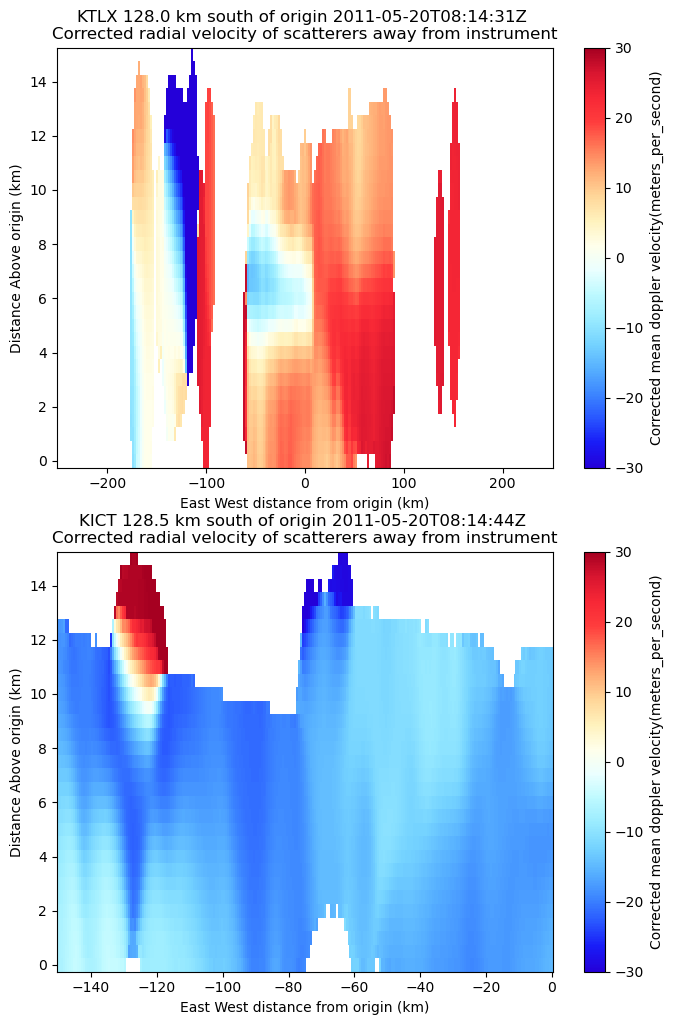

In [5]:
grid_limits = ((0., 15000.), (-150000., 0.), (-150000., 0.))
grid_shape = (31, 301, 251)

grid_sw_fine = pyart.map.grid_from_radars([radar_ktlx], grid_limits=grid_limits,
                                 grid_shape=grid_shape, gatefilter=gatefilter_sw,
                                    grid_origin=(radar_kict.latitude['data'].filled(),
                                                 radar_kict.longitude['data'].filled()))
grid_se_fine = pyart.map.grid_from_radars([radar_kict], grid_limits=grid_limits,
                                 grid_shape=grid_shape, gatefilter=gatefilter_se,
                                    grid_origin=(radar_kict.latitude['data'].filled(),
                                                 radar_kict.longitude['data'].filled()))

fig = plt.figure(figsize=(8, 12))
ax1 = plt.subplot(211)
display1 = pyart.graph.GridMapDisplay(grid_sw_coarse)
display1.plot_latitude_slice('corrected_velocity', lat=36.5, ax=ax1, fig=fig, vmin=-30, vmax=30)
ax2 = plt.subplot(212)
display2 = pyart.graph.GridMapDisplay(grid_se_fine)
display2.plot_latitude_slice('corrected_velocity', lat=36.5, ax=ax2, fig=fig, vmin=-30, vmax=30)

# Add RUC constraint to both the coarse and fine grid levels.

This section will add the Rapid Update Cycle data as a model constraint to both the coarse and fine grid levels.

In [6]:
grid_sw_coarse = pydda.constraints.add_hrrr_constraint_to_grid(grid_sw_coarse, 
                                                      pydda.tests.get_sample_file('ruc2anl_130_20110520_0800_001.grb2'),
                                                               method='linear')
grid_sw_fine = pydda.constraints.add_hrrr_constraint_to_grid(grid_sw_fine, 
                                                      pydda.tests.get_sample_file('ruc2anl_130_20110520_0800_001.grb2'),
                                                               method='linear')

skipping variable: paramId==3041 shortName='absv'
Traceback (most recent call last):
  File "/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.10/site-packages/cfgrib/dataset.py", line 680, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.10/site-packages/cfgrib/dataset.py", line 611, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,
        775.,  750.,  725.,  700.,  675.,  650.,  625.,  600.,  575.,
        550.,  525.,  500.,  475.,  450.,  425.,  400.,  375.,  350.,
        325.,  300.,  275.,  250.,  225.,  200.,  175.,  150.,  125.,
        100.])) new_value=Variable(dimensions=(), data=500.0)
skipping variable: paramId==3041 shortName='absv'
Traceback (most recent call last):
  File "/Users/r

In [18]:
included_fields = ['U_hrrr', 'V_hrrr', 'W_hrrr', 'corrected_velocity', 'DBZ']
keys = list(grid_sw_coarse.fields.keys())
for k in keys:
    if not k in included_fields:
        del grid_sw_coarse.fields[k]
keys = list(grid_se_coarse.fields.keys())
for k in keys:
    if not k in included_fields:
        del grid_se_coarse.fields[k]     
keys = list(grid_sw_fine.fields.keys())
for k in keys:
    if not k in included_fields:
        del grid_sw_fine.fields[k]
keys = list(grid_se_fine.fields.keys())
for k in keys:
    if not k in included_fields:
        del grid_se_fine.fields[k]
pyart.io.write_grid('test_coarse0.nc', grid_sw_coarse)
pyart.io.write_grid('test_coarse1.nc', grid_se_coarse)
pyart.io.write_grid('test_fine0.nc', grid_sw_fine)
pyart.io.write_grid('test_fine1.nc', grid_se_fine)

## Set up initalization for coarse grid

We only need to set up the initalization for the uppermost grid level. PyDDA will base the initalization of the retrieval for the children grids based off of an interpolation of the coarse grid over the finer grid coordinates.

In [7]:
grid_sw_coarse = pydda.initialization.make_constant_wind_field(grid_sw_coarse, (0.0, 0.0, 0.0))

# Set up PyTree structure

PyDDA incorporates nested grid using PyTrees (or dicts). This dictionary will have the following keys:

     * input_grids is the list of input grids for the given level
     * kwargs is a list of keyword arguments that overrides the default provided for this nest level if specified in this dictionary
     * output_grids is the list of output grids generated by PyDDA
     * children is a dictionary whose keys are the PyTrees corresponding to the inner nests of the specified grid. If this dictionary is empty, PyDDA will consider this set of grids to be in the innermost level of the grid nest. These children are permitted to have children of their own so that an arbitrary number of nest levels can be provided.

In [8]:
grid_tree = {}
grid_tree['input_grids'] = [grid_sw_coarse, grid_se_coarse]
grid_tree['kwargs'] = dict(Cm=256.0, Co=1e-2, Cx=1, Cy=1, Cz=1,
                           Cmod=1e-5, model_fields=["hrrr"],
                           refl_field='DBZ', wind_tol=0.5,
                           max_iterations=100, low_pass_filter=False, engine='scipy')
grid_tree_nest_1 = {}

grid_tree_nest_1['input_grids'] = [grid_sw_fine, grid_se_fine]
grid_tree_nest_1['kwargs'] = grid_tree['kwargs']
grid_tree['children'] = {'nest_1': grid_tree_nest_1}

# Do wind retrieval over nested grid

Use this to perform the retrieval over all nest levels.

In [9]:
grid_tree = pydda.retrieval.get_dd_wind_field_nested(grid_tree)

/Users/rjackson/PyDDA/pydda/retrieval/angles.py:24: RuntimeWarning: invalid value encountered in arccos
  elev = np.arccos((Re**2 + slantrsq - rh**2) / (2 * Re * slantr))
/Users/rjackson/PyDDA/pydda/retrieval/wind_retrieve.py:1532: RuntimeWarning: divide by zero encountered in divide
  inp_array2 = (x - rad2[1]) / b
/Users/rjackson/PyDDA/pydda/retrieval/wind_retrieve.py:1536: RuntimeWarning: invalid value encountered in divide
  inp_array3 = (a * a + b * b - c * c) / (2 * a * b)


Calculating weights for radars 0 and 1
Calculating weights for radars 1 and 0


/Users/rjackson/PyDDA/pydda/retrieval/wind_retrieve.py:1528: RuntimeWarning: invalid value encountered in divide
  inp_array1 = x / a
/Users/rjackson/PyDDA/pydda/retrieval/wind_retrieve.py:1536: RuntimeWarning: invalid value encountered in divide
  inp_array3 = (a * a + b * b - c * c) / (2 * a * b)


Calculating weights for models...
Starting solver 
rmsVR = 16.21367982576569
Total points: 412470
The max of w_init is 0.0
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
      0|4115.2916|   0.0000|   0.0000|   0.0000|   0.0000|11009.6044|   0.0000|   0.0000
The gradient of the cost functions is 0.3047019040107557
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     10| 177.7697|  62.8112|   0.0000|   0.0000|   0.0000| 394.2800|   0.0000|  27.6667
Max change in w: 27.363
The gradient of the cost functions is 0.06861404810857552
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     20| 107.7144|  24.6836|   0.0000|   0.0000|   0.0000| 269.6921|   0.0000|  23.0264
Max change in w: 6.433
The gradient of the cost functions is 0.011192019639019593
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     30| 108.2457|  23.2282|   0.0000|   0.

/Users/rjackson/PyDDA/pydda/retrieval/angles.py:24: RuntimeWarning: invalid value encountered in arccos
  elev = np.arccos((Re**2 + slantrsq - rh**2) / (2 * Re * slantr))
/Users/rjackson/PyDDA/pydda/retrieval/wind_retrieve.py:1532: RuntimeWarning: divide by zero encountered in divide
  inp_array2 = (x - rad2[1]) / b
/Users/rjackson/PyDDA/pydda/retrieval/wind_retrieve.py:1536: RuntimeWarning: invalid value encountered in divide
  inp_array3 = (a * a + b * b - c * c) / (2 * a * b)


Calculating weights for radars 0 and 1
Calculating weights for radars 1 and 0
Calculating weights for models...


/Users/rjackson/PyDDA/pydda/retrieval/wind_retrieve.py:1528: RuntimeWarning: invalid value encountered in divide
  inp_array1 = x / a
/Users/rjackson/PyDDA/pydda/retrieval/wind_retrieve.py:1536: RuntimeWarning: invalid value encountered in divide
  inp_array3 = (a * a + b * b - c * c) / (2 * a * b)


Starting solver 
rmsVR = 17.309754685603732
Total points: 1129552
The max of w_init is 24.091622096495087
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
      0| 718.4919| 235.2367|   0.0000|   0.0000|   0.0000|1203.4115|   0.0000|  24.0916
The gradient of the cost functions is 0.11177316983090381
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     10| 625.4280|  93.0497|   0.0000|   0.0000|   0.0000|1220.5186|   0.0000|  32.5682
Max change in w: 14.230
The gradient of the cost functions is 0.03821223617780734
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     20| 595.7675|  84.2838|   0.0000|   0.0000|   0.0000|1238.4218|   0.0000|  43.7601
Max change in w: 9.540
The gradient of the cost functions is 0.028745015202316197
Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     30| 585.7344|  83.2392|   0.0000|   0.0000|   0.0000|12

# Plot coarse resolution grid winds

For each set of grids in the node for the tree, you can visualize the nest levels using PyDDA's built in visualization techniques. Let's view the coarse grid by selecting the output_grids key of our PyTree.

/Users/rjackson/PyDDA/pydda/retrieval/wind_retrieve.py:1528: RuntimeWarning: invalid value encountered in divide
  inp_array1 = x / a
/Users/rjackson/PyDDA/pydda/retrieval/wind_retrieve.py:1536: RuntimeWarning: invalid value encountered in divide
  inp_array3 = (a * a + b * b - c * c) / (2 * a * b)
/Users/rjackson/PyDDA/pydda/vis/quiver_plot.py:301: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(
/Users/rjackson/PyDDA/pydda/retrieval/wind_retrieve.py:1532: RuntimeWarning: divide by zero encountered in divide
  inp_array2 = (x - rad2[1]) / b
/Users/rjackson/PyDDA/pydda/retrieval/wind_retrieve.py:1536: RuntimeWarning: invalid value encountered in divide
  inp_array3 = (a * a + b * b - c * c) / (2 * a * b)
/Users/rjackson/PyDDA/pydda/vis/quiver_plot.py:301: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(


<Axes: title={'center': 'PyDDA retreived winds @2.884 km'}, xlabel='X [km]', ylabel='Y [km]'>

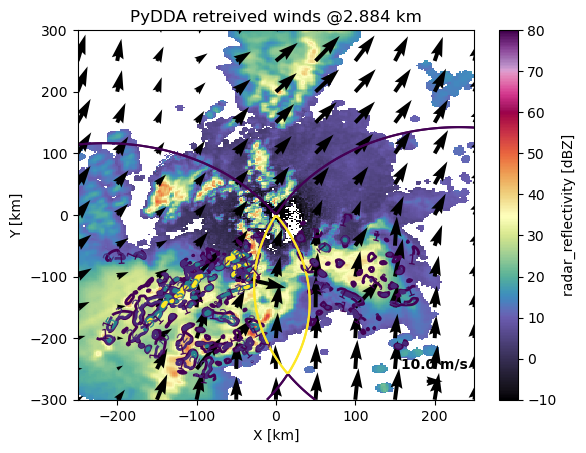

In [10]:
pydda.vis.plot_horiz_xsection_quiver(grid_tree['output_grids'], level=5, cmap='ChaseSpectral', vmin=-10, vmax=80,
                                     quiverkey_len=10.0, background_field='DBZ', bg_grid_no=1,
                                     w_vel_contours=[1, 2, 5, 10], quiver_spacing_x_km=50.0,
                                     quiver_spacing_y_km=50.0, quiverkey_loc='bottom_right')

# Plot fine resolution grids

For each set of grids in the node for the tree, you can visualize the nest levels using PyDDA's built in visualization techniques. Let's view the fine grid by selecting the output_grids key of the child named nest_1 in the PyTree.

/Users/rjackson/PyDDA/pydda/retrieval/wind_retrieve.py:1528: RuntimeWarning: invalid value encountered in divide
  inp_array1 = x / a
/Users/rjackson/PyDDA/pydda/retrieval/wind_retrieve.py:1536: RuntimeWarning: invalid value encountered in divide
  inp_array3 = (a * a + b * b - c * c) / (2 * a * b)
/Users/rjackson/PyDDA/pydda/vis/quiver_plot.py:301: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(
/Users/rjackson/PyDDA/pydda/retrieval/wind_retrieve.py:1532: RuntimeWarning: divide by zero encountered in divide
  inp_array2 = (x - rad2[1]) / b
/Users/rjackson/PyDDA/pydda/retrieval/wind_retrieve.py:1536: RuntimeWarning: invalid value encountered in divide
  inp_array3 = (a * a + b * b - c * c) / (2 * a * b)
/Users/rjackson/PyDDA/pydda/vis/quiver_plot.py:301: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(


<Axes: title={'center': 'PyDDA retreived winds @2.884 km'}, xlabel='X [km]', ylabel='Y [km]'>

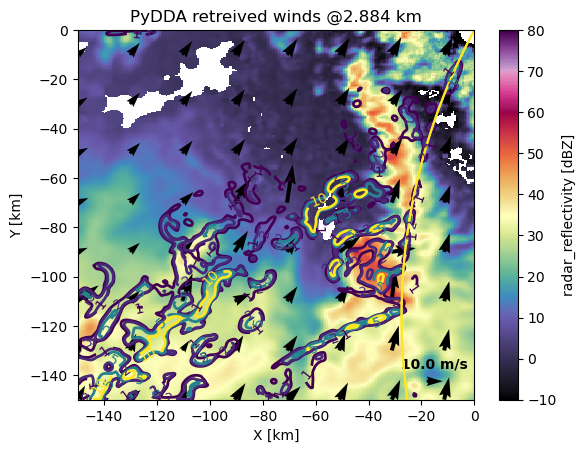

In [12]:
pydda.vis.plot_horiz_xsection_quiver(grid_tree['children']['nest_1']['output_grids'], level=5, cmap='ChaseSpectral', vmin=-10, vmax=80,
                                     quiverkey_len=10.0, background_field='DBZ', bg_grid_no=1,
                                     w_vel_contours=[1, 2, 5, 10], quiver_spacing_x_km=20.0,
                                     quiver_spacing_y_km=20.0, quiverkey_loc='bottom_right')